# Devoir portant sur les Encodeurs et Décodeurs
# NANKENG DJIMY DAMESSE MASTER I OPTION DATA SCIENCE ENSPY

# Importation des Bibliothèques

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Premier exemple : encodeur automatique de base

# Importation du Dataset

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


# Définissez un auto-encodeur avec deux couches denses : un encoder , qui comprime les images en un vecteur latent de 64 dimensions, et un decoder , qui reconstruit l'image originale à partir de l'espace latent.

# Pour définir votre modèle, utilisez l' API Keras Model Subclassing .

In [3]:
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# Entraînez le modèle en utilisant x_train comme entrée et comme cible. L' encoder apprendra à compresser l'ensemble de données de 784 dimensions à l'espace latent, et le decoder apprendra à reconstruire les images originales. .

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0237 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0117 - val_loss: 0.0108
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0

# Maintenant que le modèle est entraîné, testons-le en encodant et en décodant les images de l'ensemble de test.

In [6]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# Deuxième exemple : Débruitage d'image

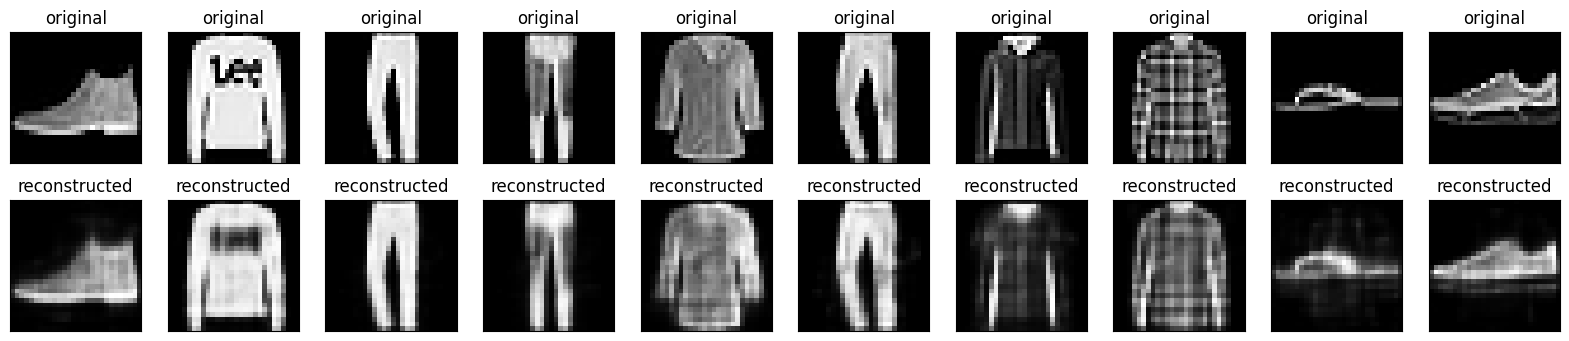

In [7]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Un auto-encodeur peut également être formé pour supprimer le bruit des images. Dans la section suivante, vous allez créer une version bruitée du jeu de données Fashion MNIST en appliquant un bruit aléatoire à chaque image. Vous entraînerez ensuite un encodeur automatique en utilisant l'image bruitée comme entrée et l'image d'origine comme cible.

# Réimportons le jeu de données pour omettre les modifications apportées précédemment

In [8]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


# Ajout de bruit aléatoire aux images

In [10]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

# Tracez les images bruitées.

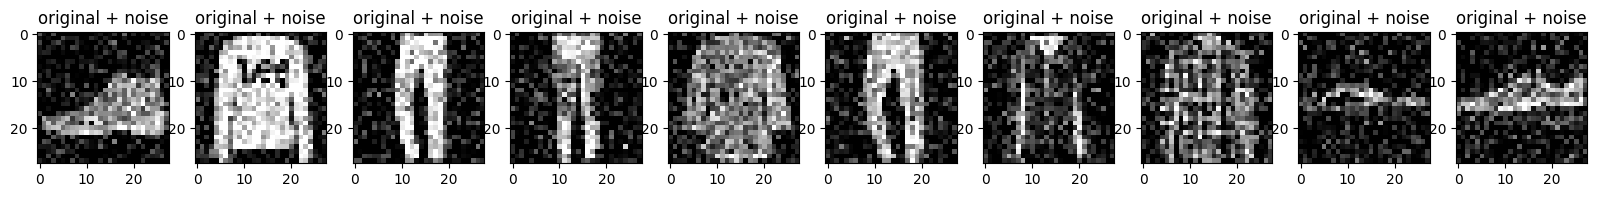

In [11]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

# Définir un auto-encodeur convolutif
# Dans cet exemple, vous allez entraîner un auto-encodeur convolutif à l'aide de couches Conv2D dans l' encoder et de couches Conv2DTranspose dans le decoder .

In [12]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [13]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [14]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 66s 34ms/step - loss: 0.0168 - val_loss: 0.0091
Epoch 2/10
1875/1875 [==============================] - 64s 34ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 3/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 4/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 5/10
1875/1875 [==============================] - 55s 30ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 6/10
1875/1875 [==============================] - 57s 31ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 7/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 8/10
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 9/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 10/10
1875/1875 [==============================] - 59s 32m

In [15]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Jetons un coup d'œil à un résumé de l'encodeur. Remarquez comment les images sont sous-échantillonnées de 28x28 à 7x7.

# Le décodeur suréchantillonne les images de 7x7 à 28x28.

In [16]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

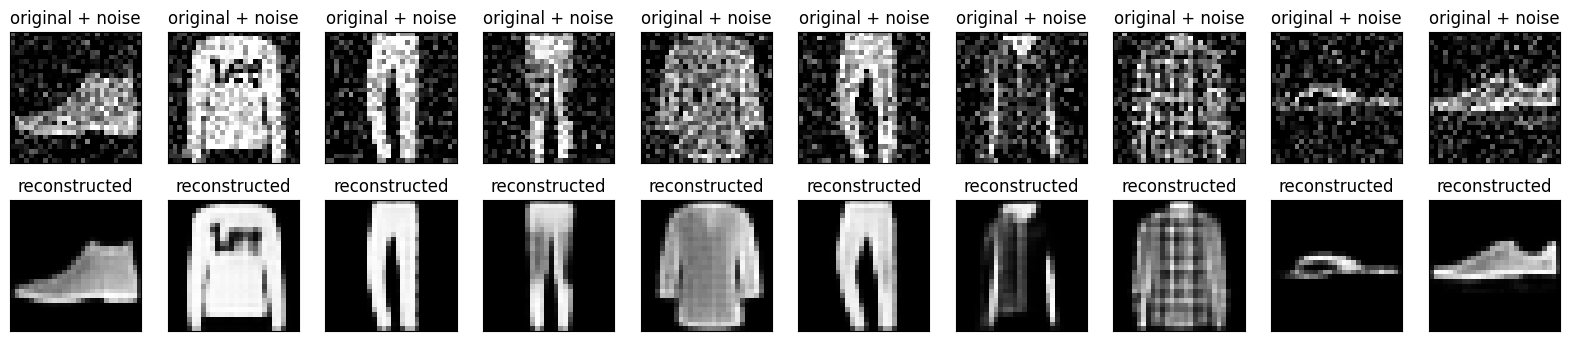

In [18]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# Troisième exemple : détection d'anomalies
# Aperçu
# Dans cet exemple, vous entraînerez un auto-encodeur pour détecter les anomalies sur le jeu de données ECG5000 . Cet ensemble de données contient 5 000 électrocardiogrammes , chacun avec 140 points de données. Vous utiliserez une version simplifiée du jeu de données, où chaque exemple a été étiqueté soit 0 (correspondant à un rythme anormal), soit 1 (correspondant à un rythme normal). Vous êtes intéressé à identifier les rythmes anormaux.

# Remarque : il s'agit d'un ensemble de données étiqueté, vous pouvez donc le formuler comme un problème d'apprentissage supervisé. Le but de cet exemple est d'illustrer les concepts de détection d'anomalies que vous pouvez appliquer à des ensembles de données plus grands, où vous n'avez pas d'étiquettes disponibles (par exemple, si vous aviez plusieurs milliers de rythmes normaux et seulement un petit nombre de rythmes anormaux).
# Comment détecterez-vous les anomalies à l'aide d'un encodeur automatique ? Rappelons qu'un auto-encodeur est formé pour minimiser l'erreur de reconstruction. Vous entraînerez un auto-encodeur sur les rythmes normaux uniquement, puis l'utiliserez pour reconstruire toutes les données. Notre hypothèse est que les rythmes anormaux auront une erreur de reconstruction plus élevée. Vous qualifierez alors un rythme d'anomalie si l'erreur de reconstruction dépasse un seuil fixé.

# Charger les données ECG
# L'ensemble de données que vous utiliserez est basé sur celui de timeseriesclassification.com .

In [19]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


# Normaliser les données à [0,1] .

In [20]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

# Vous entraînerez l'auto-encodeur en utilisant uniquement les rythmes normaux, qui sont étiquetés dans cet ensemble de données comme 1 . Séparez les rythmes normaux des rythmes anormaux.

In [21]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [22]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

# Tracez un ECG normal.

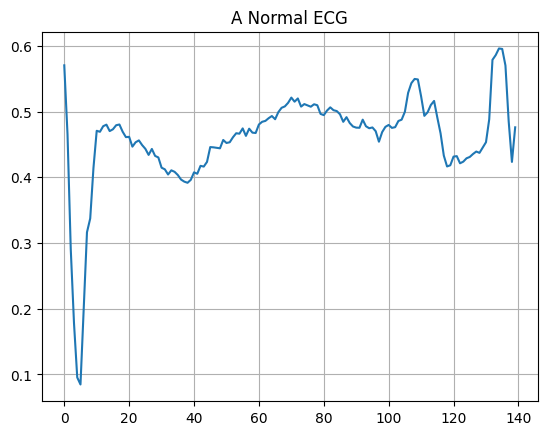

In [23]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

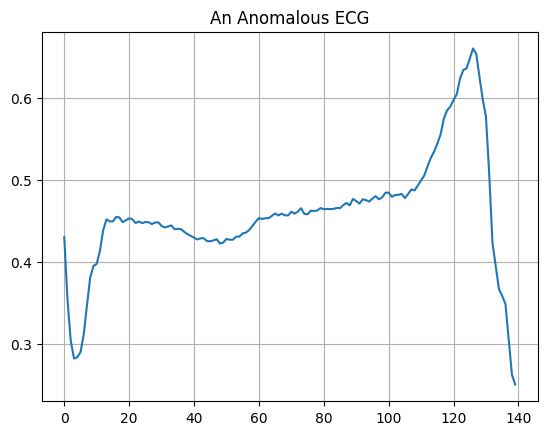

In [24]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

# Construire le modèle

In [25]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

# Notez que l'auto-encodeur est formé en utilisant uniquement les ECG normaux, mais est évalué en utilisant l'ensemble de test complet.

In [26]:
autoencoder.compile(optimizer='adam', loss='mae')

In [27]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 3s 94ms/step - loss: 0.0579 - val_loss: 0.0527
Epoch 2/20
5/5 [==============================] - 0s 33ms/step - loss: 0.0551 - val_loss: 0.0506
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0516 - val_loss: 0.0492
Epoch 4/20
5/5 [==============================] - 0s 25ms/step - loss: 0.0479 - val_loss: 0.0472
Epoch 5/20
5/5 [==============================] - 0s 37ms/step - loss: 0.0439 - val_loss: 0.0449
Epoch 6/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0403 - val_loss: 0.0436
Epoch 7/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0372 - val_loss: 0.0424
Epoch 8/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0346 - val_loss: 0.0413
Epoch 9/20
5/5 [==============================] - 0s 46ms/step - loss: 0.0325 - val_loss: 0.0404
Epoch 10/20
5/5 [==============================] - 0s 51ms/step - loss: 0.0308 - val_loss: 0.0395
Epoch 11/20
5/5 [============

# Vous classifierez bientôt un ECG comme anormal si l'erreur de reconstruction est supérieure à un écart type par rapport aux exemples d'entraînement normaux. Tout d'abord, traçons un ECG normal à partir de l'ensemble d'apprentissage, la reconstruction après son codage et son décodage par l'auto-encodeur et l'erreur de reconstruction.

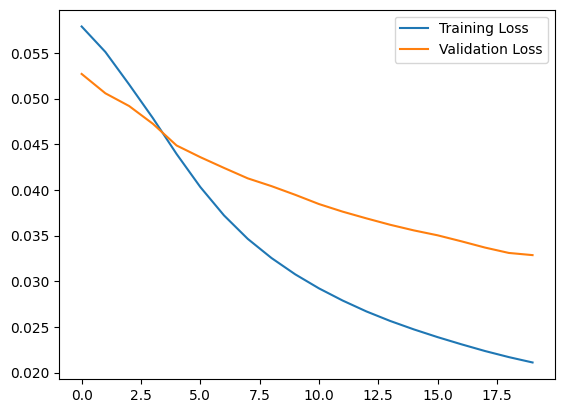

In [28]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

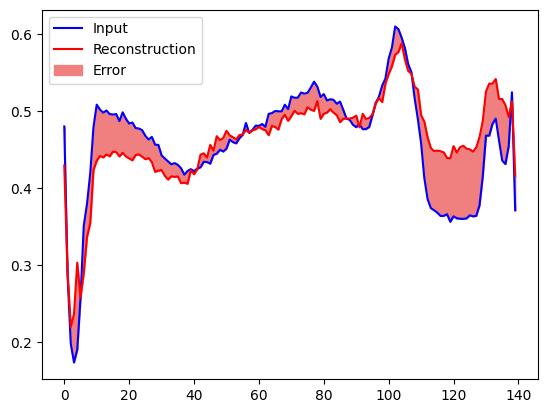

In [29]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

# Créez un tracé similaire, cette fois pour un exemple de test anormal.

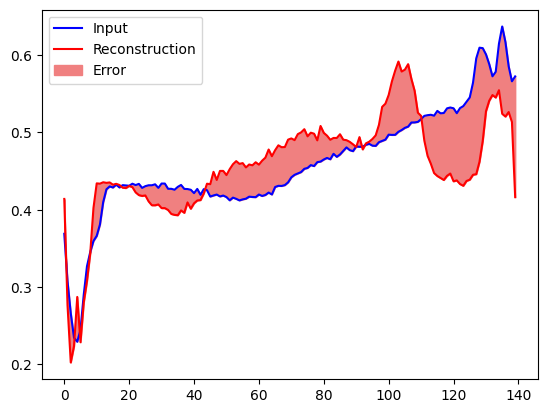

In [31]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

74/74 [==============================] - 0s 2ms/step


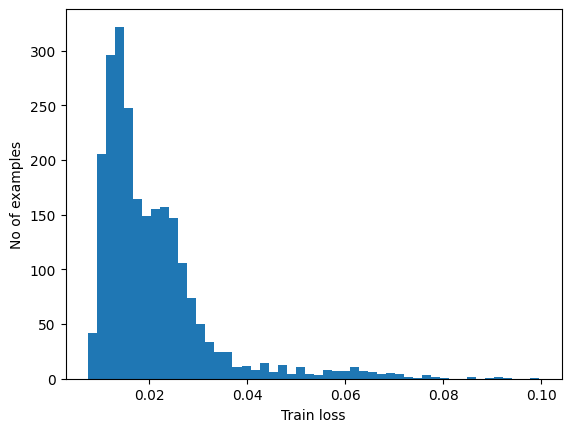

In [30]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [32]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032491405


14/14 [==============================] - 0s 2ms/step


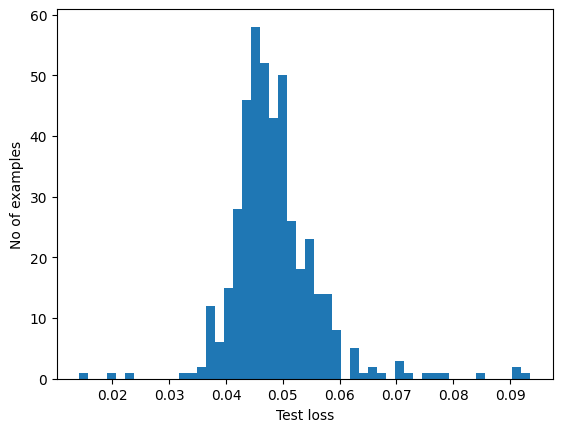

In [33]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [34]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [35]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.946
Precision = 0.9922178988326849
Recall = 0.9107142857142857


In [ ]:
pip install tensorflow